Image count: 10645


2024-07-20 09:52:55.582887: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 09:52:57.747610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-07-20 09:52:57.752517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78902 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-07-20 09:52:57.754135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 72, 112, 32)  864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 72, 112, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 72, 112, 32)  0           ['bn_Conv1[0][0]']           

2024-07-20 09:53:01.781881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


 29/566 [>.............................] - ETA: 3s - loss: 1.2704 - mae: 0.8949 

2024-07-20 09:53:03.447624: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


566/566 [==============================] - 8s 7ms/step - loss: 0.4184 - mae: 0.4942 - val_loss: 0.1760 - val_mae: 0.3274
Epoch 2/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.2041 - mae: 0.3584 - val_loss: 0.1730 - val_mae: 0.3220
Epoch 3/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1919 - mae: 0.3451 - val_loss: 0.1681 - val_mae: 0.3136
Epoch 4/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1861 - mae: 0.3395 - val_loss: 0.1695 - val_mae: 0.3118
Epoch 5/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1843 - mae: 0.3363 - val_loss: 0.1636 - val_mae: 0.3124
Epoch 6/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1778 - mae: 0.3305 - val_loss: 0.1593 - val_mae: 0.3018
Epoch 7/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1769 - mae: 0.3282 - val_loss: 0.1635 - val_mae: 0.3066
Epoch 8/2000
566/566 [==============================] - 3s 6ms/step - loss:

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Save at: model/Sat Jul 20 09:52:41 2024


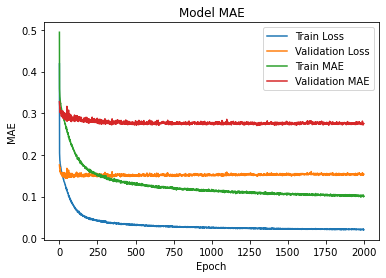

In [1]:
import numpy as np
import glob
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import time
import re


def load_catalogs(folder: str):
    _img_name = []
    _angle = []
    _throttle = []

    for _file in sorted(glob.glob(f"{folder}/*.catalog"),
                        key=lambda x: [
                            int(c) if c.isdigit()
                            else c for c in re.split(r'(\d+)', x)]):
        with open(_file) as f:
            for _line in f:
                _img_name.append(_line.split()[7][1:-2])
                _angle.append(float(_line.split()[9][0:-1]))
                _throttle.append(float(_line.split()[13][0:-1]))

    print(f'Image count: {len(_img_name)}')
    return _img_name, _angle, _throttle


def load_images(_img_name: list, folder: str):
    _image = []
    for i in range(len(_img_name)):
        _img = cv2.imread(os.path.join(f"{folder}/images", _img_name[i]))
        assert _img.shape == (224, 224, 3),\
            "img %s has shape %r" % (_img_name[i], _img.shape)
        _image.append(_img)
    return _image


def data_preprocessing(_throttle, _angle, _image):
    _throttle = np.array(_throttle)
    _steering = np.array(_angle)
    _train_img = np.array(_image)
    _label = _steering
    _cut_height = 80
    _train_img_cut_orig = _train_img[:, _cut_height:224, :]
    # _train_img_cut_gray = np.dot(_train_img_cut_orig[..., :3],
    #                              [0.299, 0.587, 0.114])
    _train_img_cut_gray = _train_img_cut_orig
    return _train_img_cut_orig, _train_img_cut_gray, _label


def train_split(_train_img_cut_orig, _train_img_cut_gray, _label):
    _X_train, _X_val, _y_train, _y_val = train_test_split(
        _train_img_cut_gray, _label,
        test_size=0.15, random_state=42)
    return _X_train, _X_val, _y_train, _y_val


def build_fine_tuned_mobilenetv2_model(input_shape):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    _x = base_model.output
    _x = GlobalAveragePooling2D()(_x)
    _x = Dense(1024, activation='relu')(_x)
    _x = Dropout(0.5)(_x)
    _outputs = Dense(1, activation='linear')(_x)

    _model = Model(inputs=base_model.input, outputs=_outputs)
    return _model


def train_start(_model, _X_train, _X_val, _y_train, _y_val, 
                epochs: int=100, batch_size: int=16):
    _optimizer = tf.optimizers.Adam(learning_rate=0.0001,
                                    beta_1=0.9, beta_2=0.999)
    _model.compile(optimizer=_optimizer, loss="mse", metrics=["mae"])
    _model.summary()
    _trained_model = _model.fit(_X_train, _y_train,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(_X_val, _y_val))
    return _trained_model


def plot_trained_model(_trained_model, 
                       show: bool=False,
                       save: bool=True,
                       save_folder: str=''):
    
    history = _trained_model.history

    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_folder, f'Loss.png'),
                    bbox_inches='tight')
    if show:
        plt.show()

    plt.plot(history['mae'], label='Train MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_folder, f'MAE.png'),
                    bbox_inches='tight')
    if show:
        plt.show()


if __name__ == "__main__":
    data_folder = "../data/data_0202"
    save_folder = f"model/{time.ctime(time.time())}"
    # create save path
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder, exist_ok=True)
    
    img_name, angle, throttle = load_catalogs(data_folder)
    image = load_images(img_name, data_folder)
    image = np.array(image)
    train_img_cut_orig, train_img_cut_gray, label = data_preprocessing(
        throttle, angle, image)
    X_train, X_val, y_train, y_val = train_split(
        train_img_cut_orig, train_img_cut_gray, label)

    # Update input shape for MobileNetV2
    model = build_fine_tuned_mobilenetv2_model(input_shape=(144, 224, 3))
    trained_model = train_start(model, X_train, X_val, y_train, y_val, 
                               epochs=2000)
    plot_trained_model(trained_model, show=False, save=True, save_folder=save_folder)
    model.save(os.path.join(save_folder, f"model.h5"))
    print(f"Save at: {save_folder}")


### Save at: model/Sat Jul 20 09:52:41 2024

Image count: 10645


2024-07-21 03:07:51.553611: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 03:07:53.537872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-07-21 03:07:53.539673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78902 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-07-21 03:07:53.543403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 72, 112, 32)  864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 72, 112, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 72, 112, 32)  0           ['bn_Conv1[0][0]']           

2024-07-21 03:07:57.592124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


 28/566 [>.............................] - ETA: 3s - loss: 1.1754 - mae: 0.8690 

2024-07-21 03:07:59.232748: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


566/566 [==============================] - 8s 8ms/step - loss: 0.4048 - mae: 0.4861 - val_loss: 0.1874 - val_mae: 0.3429
Epoch 2/2000
  1/566 [..............................] - ETA: 3s - loss: 0.1720 - mae: 0.3163

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


566/566 [==============================] - 3s 6ms/step - loss: 0.2060 - mae: 0.3582 - val_loss: 0.1734 - val_mae: 0.3211
Epoch 3/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1920 - mae: 0.3455 - val_loss: 0.1795 - val_mae: 0.3302
Epoch 4/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1866 - mae: 0.3390 - val_loss: 0.1665 - val_mae: 0.3135
Epoch 5/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1790 - mae: 0.3316 - val_loss: 0.1678 - val_mae: 0.3112
Epoch 6/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1794 - mae: 0.3319 - val_loss: 0.1683 - val_mae: 0.3189
Epoch 7/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1757 - mae: 0.3273 - val_loss: 0.1651 - val_mae: 0.3182
Epoch 8/2000
566/566 [==============================] - 3s 6ms/step - loss: 0.1732 - mae: 0.3265 - val_loss: 0.1618 - val_mae: 0.3062
Epoch 9/2000
566/566 [==============================] - 3s 6ms/step - loss:

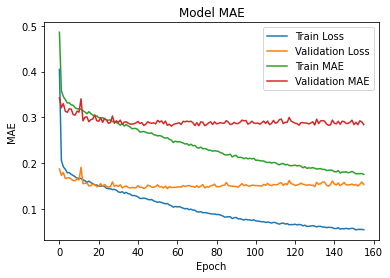

In [1]:
import numpy as np
import glob
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import time
import re


def load_catalogs(folder: str):
    _img_name = []
    _angle = []
    _throttle = []

    for _file in sorted(glob.glob(f"{folder}/*.catalog"),
                        key=lambda x: [
                            int(c) if c.isdigit()
                            else c for c in re.split(r'(\d+)', x)]):
        with open(_file) as f:
            for _line in f:
                _img_name.append(_line.split()[7][1:-2])
                _angle.append(float(_line.split()[9][0:-1]))
                _throttle.append(float(_line.split()[13][0:-1]))

    print(f'Image count: {len(_img_name)}')
    return _img_name, _angle, _throttle


def load_images(_img_name: list, folder: str):
    _image = []
    for i in range(len(_img_name)):
        _img = cv2.imread(os.path.join(f"{folder}/images", _img_name[i]))
        assert _img.shape == (224, 224, 3),\
            "img %s has shape %r" % (_img_name[i], _img.shape)
        _image.append(_img)
    return _image


def data_preprocessing(_throttle, _angle, _image):
    _throttle = np.array(_throttle)
    _steering = np.array(_angle)
    _train_img = np.array(_image)
    _label = _steering
    _cut_height = 80
    _train_img_cut_orig = _train_img[:, _cut_height:224, :]
    # _train_img_cut_gray = np.dot(_train_img_cut_orig[..., :3],
    #                              [0.299, 0.587, 0.114])
    _train_img_cut_gray = _train_img_cut_orig
    return _train_img_cut_orig, _train_img_cut_gray, _label


def train_split(_train_img_cut_orig, _train_img_cut_gray, _label):
    _X_train, _X_val, _y_train, _y_val = train_test_split(
        _train_img_cut_gray, _label,
        test_size=0.15, random_state=42)
    return _X_train, _X_val, _y_train, _y_val


def build_fine_tuned_mobilenetv2_model(input_shape):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    _x = base_model.output
    _x = GlobalAveragePooling2D()(_x)
    _x = Dense(1024, activation='relu')(_x)
    _x = Dropout(0.5)(_x)
    _outputs = Dense(1, activation='linear')(_x)

    _model = Model(inputs=base_model.input, outputs=_outputs)
    return _model


def train_start(_model, _X_train, _X_val, _y_train, _y_val, 
                epochs: int=100, batch_size: int=16, patience: int=100, save_folder: str=''):
    _optimizer = tf.optimizers.Adam(learning_rate=0.0001,
                                    beta_1=0.9, beta_2=0.999)
    _model.compile(optimizer=_optimizer, loss="mse", metrics=["mae"])
    _model.summary()
    
    # Add EarlyStopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=patience, 
                                                  restore_best_weights=True)
    
    # Add ModelCheckpoint callback to save the best model
    best_model_path = os.path.join(save_folder, "best_model.h5")
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_path, 
                                                          monitor='val_loss', 
                                                          save_best_only=True)
    
    _trained_model = _model.fit(_X_train, _y_train,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(_X_val, _y_val),
                                callbacks=[early_stop, model_checkpoint])
    return _trained_model


def plot_trained_model(_trained_model, 
                       show: bool=False,
                       save: bool=True,
                       save_folder: str=''):
    
    history = _trained_model.history

    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_folder, f'Loss.png'),
                    bbox_inches='tight')
    if show:
        plt.show()

    plt.plot(history['mae'], label='Train MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_folder, f'MAE.png'),
                    bbox_inches='tight')
    if show:
        plt.show()


if __name__ == "__main__":
    data_folder = "../data/data_0202"
    save_folder = f"model/{time.ctime(time.time())}"
    # create save path
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder, exist_ok=True)
    
    img_name, angle, throttle = load_catalogs(data_folder)
    image = load_images(img_name, data_folder)
    image = np.array(image)
    train_img_cut_orig, train_img_cut_gray, label = data_preprocessing(
        throttle, angle, image)
    X_train, X_val, y_train, y_val = train_split(
        train_img_cut_orig, train_img_cut_gray, label)

    # Update input shape for MobileNetV2
    model = build_fine_tuned_mobilenetv2_model(input_shape=(144, 224, 3))
    trained_model = train_start(model, X_train, X_val, y_train, y_val, 
                               epochs=2000, save_folder=save_folder)
    plot_trained_model(trained_model, show=False, save=True, save_folder=save_folder)
    
    # Save the last model
    model.save(os.path.join(save_folder, "last_model.h5"))
    
    print(f"Models saved at: {save_folder}")


### Models saved at: model/Sun Jul 21 03:07:34 2024